## Morris Lecar Model

Computational Neuroscience is a branch of neuroscience which makes use of mathematical models and theoretical analysis in attempting to understand the principles that govern brain function. Central to the field is the development and use of mathematical models of individual neurons, which attempt to replicate the response of neurons to environmental conditions and external stimuli. Variations and combinations of these models allow for the modelling of entire neurological systems. One such mathematical model is the Morris-Lecar neuron.

The Morris-Lecar neuron is a model of a neuron with three ion channels and an external applied current $I$. The conductance varies across the $K^+$ and $Ca^{2+}$ ion channels, but is static across the $L^+$ channel. The $Ca^{2+}$ ion channel which has an instantaneously responding conductance relative to voltage, is used for excitation (entering an excited, spiking state). The $K^+$ ion channel whose conductance has a delayed response to changes in voltage, is used for recovery (returning to resting state).

According to the roles of each ion channel, the formal system of differential equations describing the system is:

$C\frac{dV}{dt} = I - g_L(V-V_L) - g_{Ca}M_{ss}(V-V_{Ca}) - g_KN(V-V_K)$

$\frac{dN}{dt} = \frac{N_{ss}(V) - N}{\tau_N(V)}$

where C is the capacitance of the cell membrane, V is the voltage across the membrane, $g_L$, $g_{Ca}$, and $g_K$ are the conductances across each of the ion channels, $V_L$, $V_{Ca}$, and $V_K$ are the equilibrium voltages of each of the ion channels, N is the recovery variable, and:

$M_{ss} = (1+tanh[(V-V_1)/V_2])/2$

$N_{ss} = (1+tanh[(V-V_3)/V_4])/2$

Additionally, $\tau_N$ serves as the time constant for the relaxation caused by the $K^+$ ion channel in response to changes in voltage. It can formally be written as:

$\tau_N(V) = \tau_0sech[(V-V_3)/2V_4]$

where $\tau_0$ sets the time scale of the analysis (this is equivalent to the $\frac{1}{\phi cosh[(V-V_3)/2V_4]}$ used below, where $\phi$ is the reference frequency, and is the reciprocal of $\tau_0$)

In order to gain a better understanding of this model, let's first look at what the variables stand for.

* N is the instantaneous probability that a K^+ ion channel is in its open (conducting state)
* The equation for $\frac{dN}{dt}$ describes the process by which protein channels transition between non-conducting and conducting states
* $M_ss$ and $N_ss$ are the open-state probability functions for the $Ca^{2+}$ and $K^+$ ion channels

In this notebook, we will be viewing the response of a Morris-Lecar neuron to various input currents.

To begin, we set the parameters for the neuron:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from copy import copy

global V
global N
# Assign values to variables
C = 6.69810502993 # Capacitance of membrane
V_1 = 30 # Tuning parameters for steady state and time constant
V_2 = 15
V_3 = 0
V_4 = 30
phi = 0.025 # reference frequency
V_L = -50 # Equilibrum potentials for ion channels
V_Ca = 100
V_K = -70
g_Ca = 1.1 # leak, conductances through membrane for each ion
g_K = 2
g_L = 0.5
V = -52.14 # Membrane potential
N = 0.02 # Recovery variance
V_init = copy(V)
N_init = copy(N)

We instantiate the system of differential equations as a set of lambda functions:

In [2]:
#Define functions
M_ss = lambda: (1/2) * (1 + np.tanh((V - V_1) / V_2))
N_ss = lambda: (1/2) * (1 + np.tanh((V - V_3) / V_4))
T_N = lambda: 1 / (phi * np.cosh((V - V_3) / (2 * V_4)))

#Define differential equations
dV = lambda I: (I - g_L * (V - V_L) - g_Ca * M_ss() * (V - V_Ca) - g_K * N * (V - V_K)) / C
dN = lambda: (N_ss() - N) / T_N()

#Equations for the input of each channel
L = lambda: - g_L * (V - V_L)
Ca = lambda: - g_Ca * M_ss() * (V - V_Ca)
K = lambda: - g_K * N * (V - V_K)

We define functions to run a simulation of a neuron based on an inputted current, as well as plot the results:

In [3]:
import pandas as pd

def run_model(current):
    global V
    global N
    
    #Reset variables
    V = copy(V_init)
    N = copy(N_init)
    
    data = {
        "t" : [],
        "I" : [],
        "V" : [],
        "N" : [],
        "L" : [],
        "Ca" : [],
        "K" : [],
        "N_ss" : [],
        "T_N" : []
    }

    for t, I in zip(range(len(current)), current):
        #Update variables
        V = V + dV(I)
        N = N + dN()
        #Update DataFrame
        data["t"].append(t)
        data["I"].append(I)
        data["V"].append(V)
        data["N"].append(N)
        data["L"].append(L())
        data["Ca"].append(Ca())
        data["K"].append(K())
        data["N_ss"].append(N_ss())
        data["T_N"].append(T_N())
    
    return pd.DataFrame.from_dict(data)
def plot_model(data):
    for  col in data.keys():
        if col in ["t", "I", "L"]: continue
        plt.plot(data[col]/mean(data[col]))
    plt.legend(loc="upper right")
    plt.show()

Having defined the model and set its parameters, we can move on to experimentation.

First, we experiment with a random input current

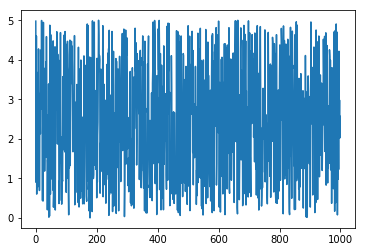

In [4]:
#Generate an input stimulus
scale = 5
length = 1000
center = 5e-10
current = list(scale * np.random.random((length)) + center)

plt.plot(current)
plt.show()

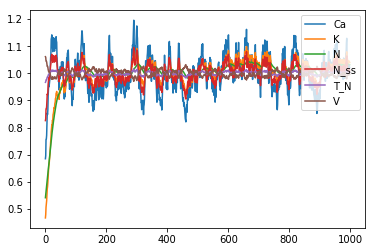

In [5]:
data = run_model(current)
plot_model(data)

As the cell is subjected to a constant above-zero input current, we can see that the recovery variable, $N$, increases. This stops the voltage in the cell from growing uncontrollably.

Next, we look at a square pulse stimulus:

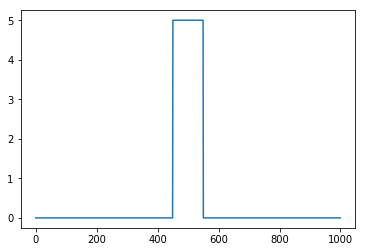

In [6]:
# Generate an input stimulus
value = 5
length = 1000
begin = 450
end = 550
current = [0 for _ in range(length)]
current[begin:end] = [value for _ in range(end-begin)]
plt.plot(current)
plt.show()

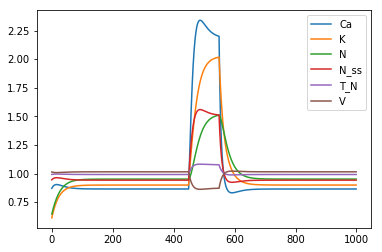

In [7]:
data = run_model(current)
plot_model(data)

The above graph is a good visualization for the similarities between the release of current from a dielectric and from a neuron's membrane. We can see that our model neuron's membrane experiences exponential decay in the release of current, just as a dielectric does. This demonstrates how the membrane of a neuron acts as a dielectric.

Finally, we will be looking at a sinusoidal stimulus:

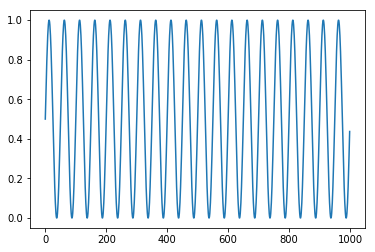

In [8]:
# Generate an input stimulus
scale = 5e-1
step = np.pi/25
base = 5e-1
length = 1000
current = [scale * np.sin(step*i) + base for i in range(length)]
plt.plot(current)
plt.show()

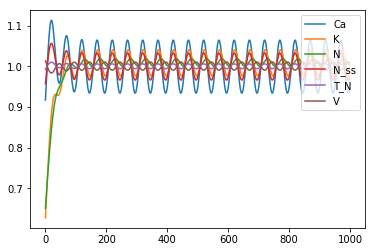

In [9]:
data = run_model(current)
plot_model(data)

As we can see from the above graph, the injection of a 0.5 Ampere sinusoidal stimulus causes the cell's voltage to oscillate. This is caused by the interplay between the recovery variable $N$ and the voltage $V$. As the voltage increases, the recovery variable moves to counteract it by increasing the influence of the $K^+$ ion gate on the voltage. However, this response is delayed. This delay allows for the system of oscillate between voltage levels. More technically, we would say that the sinusoidal stimulus caused the system to bifurcate from a resting state to an oscillating, or firing, state. This state can also be visualized based on the phase portrait shown below. As the system begins to oscillate, it moves from a single point (resting state) to an elliptical path (oscillating state).

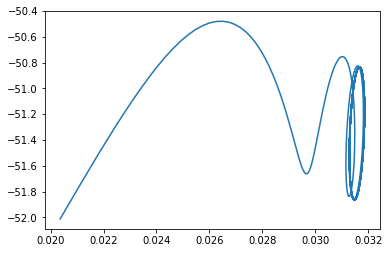

In [10]:
plt.plot(data["N"], data["V"])
plt.show()